# Setting

In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from tqdm import tqdm
from itertools import combinations
import re


In [2]:
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

In [3]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
print(f'Train Image : {len(pngs)}, json : {len(jsons)}')

pngs = sorted(list(pngs))
jsons = sorted(list(jsons))
print(f'Image file name e.g.) {pngs[0]}\njson file name e.g.) {jsons[0]}')

Train Image : 800, json : 800
Image file name e.g.) ID001/image1661130828152_R.png
json file name e.g.) ID001/image1661130828152_R.json


In [4]:
def read_json_and_inspect(json_rel_path):
    json_path = os.path.join(LABEL_ROOT, json_rel_path)
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# 첫 번째 JSON 파일 구조 확인
sample_json_path = jsons[0]
sample_data = read_json_and_inspect(sample_json_path)

print(f"File: {sample_json_path}")
print("Keys:", sample_data.keys())
# 'annotations' 키가 있는지, 내부 구조가 어떤지 확인용 출력
if 'annotations' in sample_data:
    print("First annotation example:", sample_data['annotations'][0])

File: ID001/image1661130828152_R.json
Keys: dict_keys(['annotations', 'attributes', 'file_id', 'filename', 'parent_path', 'last_modifier_id', 'metadata', 'last_workers'])
First annotation example: {'id': '30-f037db6e-aef2-4156-93e2-8de7cc97869c', 'type': 'poly_seg', 'attributes': {}, 'points': [[960, 2047], [960, 2046], [960, 2045], [960, 2044], [960, 2043], [960, 2042], [960, 2041], [959, 2041], [959, 2040], [959, 2039], [959, 2038], [959, 2037], [959, 2036], [959, 2035], [959, 2034], [959, 2033], [959, 2032], [959, 2031], [959, 2030], [959, 2029], [959, 2028], [959, 2027], [959, 2026], [959, 2025], [958, 2025], [958, 2024], [958, 2023], [958, 2022], [958, 2021], [958, 2020], [958, 2019], [958, 2018], [958, 2017], [958, 2016], [958, 2015], [958, 2014], [958, 2013], [958, 2012], [958, 2011], [958, 2010], [958, 2009], [958, 2008], [958, 2007], [958, 2006], [958, 2005], [957, 2005], [957, 2004], [957, 2003], [957, 2002], [957, 2001], [957, 2000], [957, 1999], [957, 1998], [957, 1997], [9

Image: ID284/image1664156207361.png
Number of annotations: 29


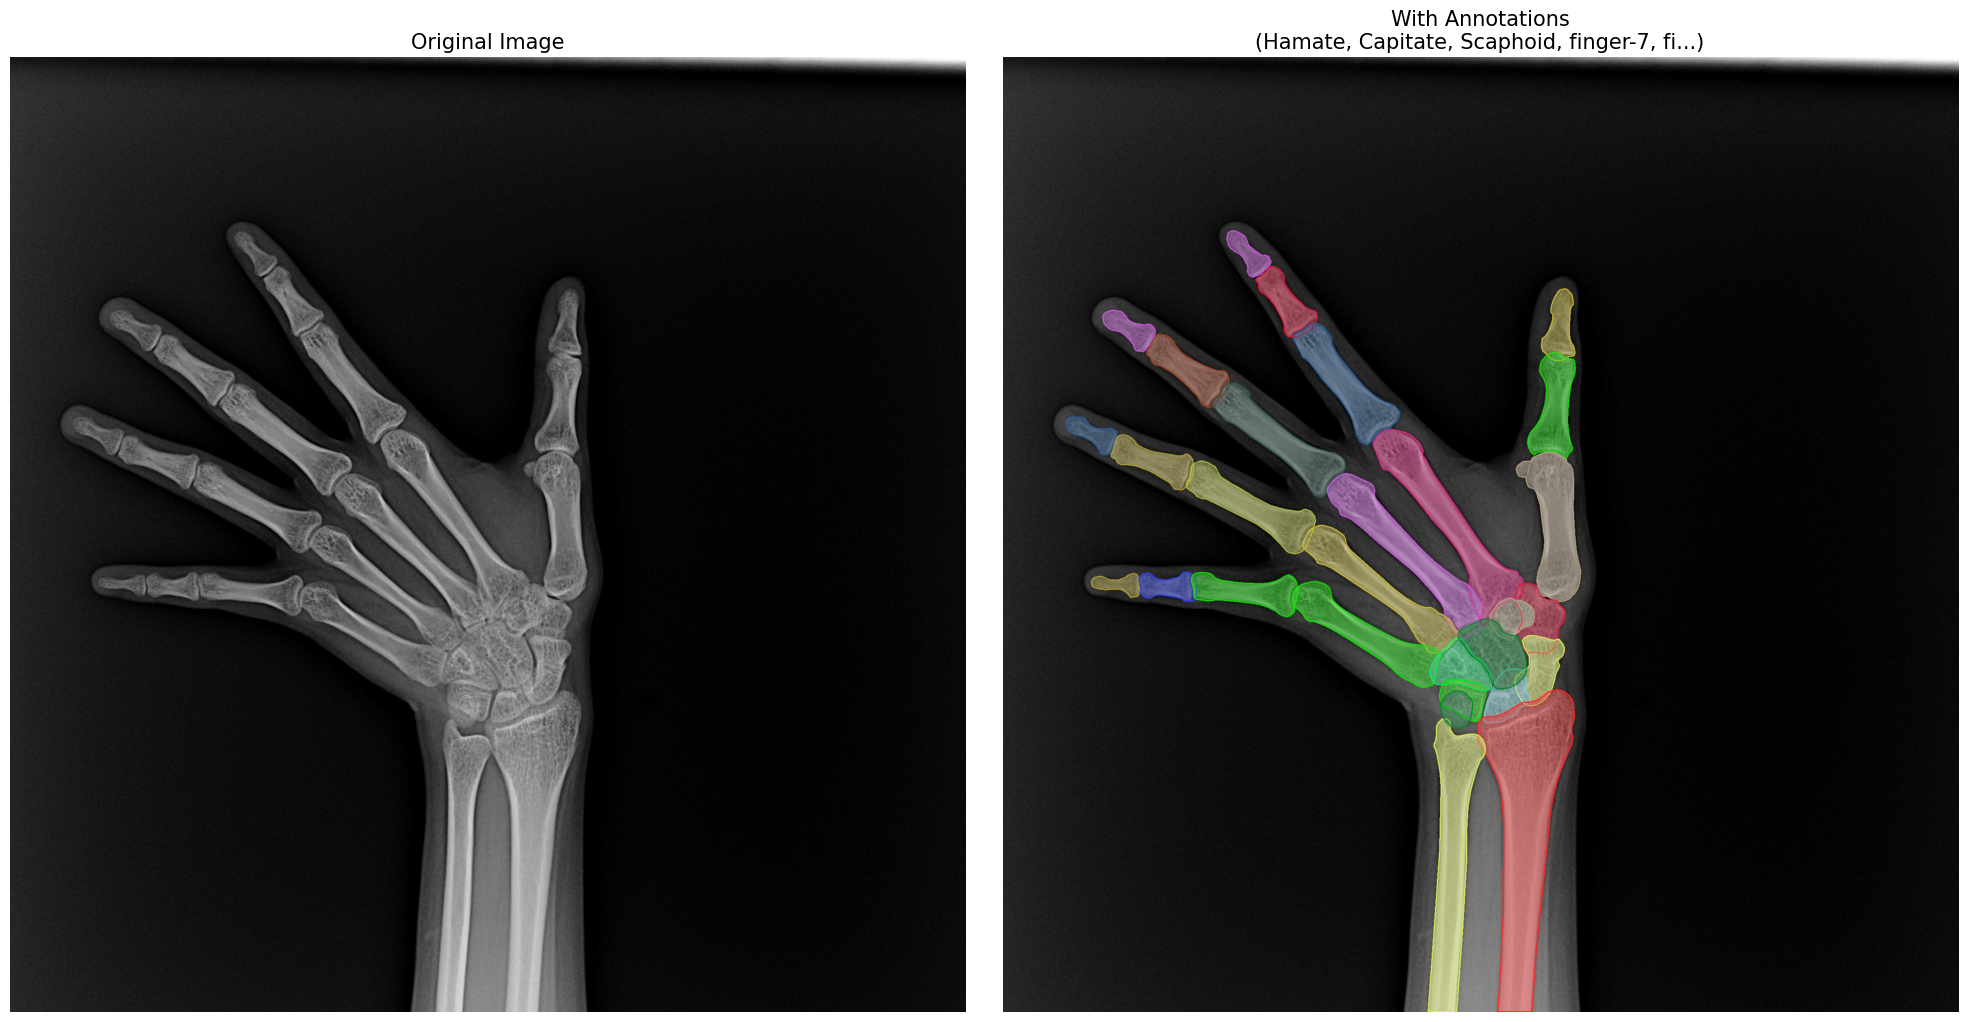

In [5]:
COLORS = np.random.randint(0, 255, size=(30, 3), dtype="uint8")

def visualize_sample(index, alpha=0.4):

    png_filename = pngs[index]
    json_filename = jsons[index]

    img_path = os.path.join(IMAGE_ROOT, png_filename)
    json_path = os.path.join(LABEL_ROOT, json_filename)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    original_img = img.copy()  # 왼쪽 화면용 (깨끗한 원본)
    vis_img = img.copy()       # 오른쪽 화면용 (그림 그릴 대상)
    overlay = img.copy()       # 투명도 조절용
    
    # JSON 로드
    with open(json_path, 'r') as f:
        data = json.load(f)

    annotations = data.get('annotations', [])
    print(f"Image: {png_filename}")
    print(f"Number of annotations: {len(annotations)}")
    
    class_names_in_img = set()
    
    for ann in annotations:
        label = ann.get('label', 'unknown')
        points = ann.get('points', [])
        
        class_names_in_img.add(label)
        
        # 포인트를 numpy 배열로 변환
        pts = np.array(points, np.int32)
        pts = pts.reshape((-1, 1, 2))
        
        # 클래스 이름에 따라 색상 결정
        color_idx = hash(label) % len(COLORS)
        color = COLORS[color_idx].tolist()
        
        cv2.fillPoly(overlay, [pts], color)
        cv2.polylines(vis_img, [pts], True, color, 2)
        
    vis_img = cv2.addWeighted(overlay, alpha, vis_img, 1 - alpha, 0)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 
    
    # 왼쪽: 원본 이미지
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image", fontsize=15)
    axes[0].axis('off')
    
    # 오른쪽: 폴리곤 적용 이미지
    axes[1].imshow(vis_img)
    axes[1].set_title(f"With Annotations\n({', '.join(list(class_names_in_img))[:40]}...)", fontsize=15)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

import random
random_idx = random.randint(0, len(pngs)-1)
visualize_sample(random_idx)

# EDA 

In [6]:
area_data = []

print("Calculating area for all annotations...")
for json_file in tqdm(jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    
    with open(json_path, 'r') as f:
        data = json.load(f)
        
    annotations = data.get('annotations', [])
    for ann in annotations:
        label = ann.get('label')
        points = ann.get('points', [])
        
        if label and len(points) > 2:
            pts_array = np.array(points, dtype=np.int32)
            area = cv2.contourArea(pts_array)
            
            area_data.append({
                'label': label,
                'area': area
            })

df_area = pd.DataFrame(area_data)
annotation_order = df_area['label'].unique().tolist()

# Box Plot
fig = px.box(
    df_area, 
    x='area', 
    y='label', 
    color='label',          
    log_x=True,             
    points="outliers",      
    title="Distribution of Annotation Areas per Class (Log Scale)",
    template='plotly_white', 
    category_orders={'label': annotation_order} 
)

fig.update_layout(
    xaxis_title="Area (pixels) - Log Scale",
    yaxis_title="Class Name",
    showlegend=False,   
    height=max(600, 30 * len(annotation_order)), 
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.update_traces(hovertemplate='<b>%{y}</b><br>Area: %{x}')
fig.show()

print("\nTop 5 Smallest Classes (Average Area)")
print(df_area.groupby('label')['area'].mean().sort_values().head(5))

print("\nTop 5 Largest Classes (Average Area)")
print(df_area.groupby('label')['area'].mean().sort_values().tail(5))

Calculating area for all annotations...


100%|██████████| 800/800 [00:05<00:00, 147.84it/s]



Top 5 Smallest Classes (Average Area)
label
finger-16    3895.288125
Pisiform     4327.918750
finger-4     4950.274375
finger-12    5667.932500
finger-8     5743.516250
Name: area, dtype: float64

Top 5 Largest Classes (Average Area)
label
finger-3     26665.601875
finger-11    32277.823750
finger-7     35310.504375
Ulna         39455.527500
Radius       75127.619375
Name: area, dtype: float64


Analyzing Pixel Intensity from 100 sample images...


100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


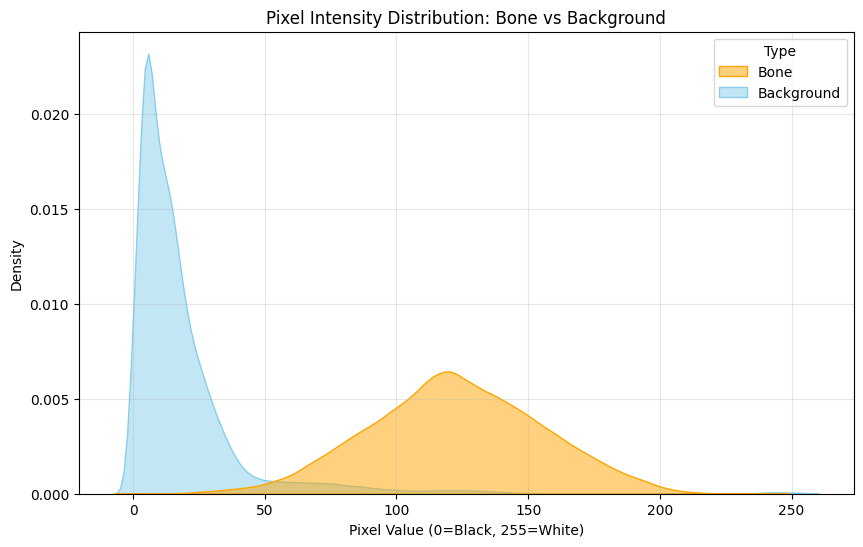

                  mean        std
Type                             
Background   18.993404  25.102417
Bone        122.472468  32.992577


In [7]:
SAMPLE_IMAGES = 100  # 전체를 다 하면 느리므로 100장만 샘플링
PIXEL_SAMPLE_SIZE = 5000 # 이미지당 추출할 픽셀 수

intensity_data = []

print(f"Analyzing Pixel Intensity from {SAMPLE_IMAGES} sample images...")

# 랜덤하게 이미지 선택
import random
sample_indices = random.sample(range(len(jsons)), min(len(jsons), SAMPLE_IMAGES))
sample_jsons = [jsons[i] for i in sample_indices]

for json_file in tqdm(sample_jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    png_filename = json_file.replace('.json', '.png')
    img_path = os.path.join(IMAGE_ROOT, png_filename)
    
    # Grayscale 로드
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    
    # Mask 생성 (0: 배경, 1: 뼈)
    mask = np.zeros_like(img, dtype=np.uint8)
    
    annotations = data.get('annotations', [])
    for ann in annotations:
        points = ann.get('points', [])
        if len(points) > 2:
            pts = np.array(points, np.int32)
            cv2.fillPoly(mask, [pts], 1)
            
    # 픽셀 추출
    bone_pixels = img[mask == 1]
    bg_pixels = img[mask == 0]
    
    # 데이터가 너무 많으면 시각화가 느리므로 랜덤 샘플링해서 저장
    if len(bone_pixels) > 0:
        sampled = np.random.choice(bone_pixels, size=min(len(bone_pixels), PIXEL_SAMPLE_SIZE // 2))
        for p in sampled:
            intensity_data.append({'Intensity': p, 'Type': 'Bone'})
            
    if len(bg_pixels) > 0:
        sampled = np.random.choice(bg_pixels, size=min(len(bg_pixels), PIXEL_SAMPLE_SIZE // 2))
        for p in sampled:
            intensity_data.append({'Intensity': p, 'Type': 'Background'})

df_intensity = pd.DataFrame(intensity_data)

# 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_intensity, x='Intensity', hue='Type', fill=True, 
            palette={'Bone': 'orange', 'Background': 'skyblue'}, alpha=0.5)

plt.title("Pixel Intensity Distribution: Bone vs Background")
plt.xlabel("Pixel Value (0=Black, 255=White)")
plt.grid(True, alpha=0.3)
plt.show()

# 통계적 수치 확인 (평균 밝기 차이)
print(df_intensity.groupby('Type')['Intensity'].describe()[['mean', 'std']])

Analyzing Anatomical Spatial Consistency (Centroids)...


  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:07<00:00, 108.92it/s]


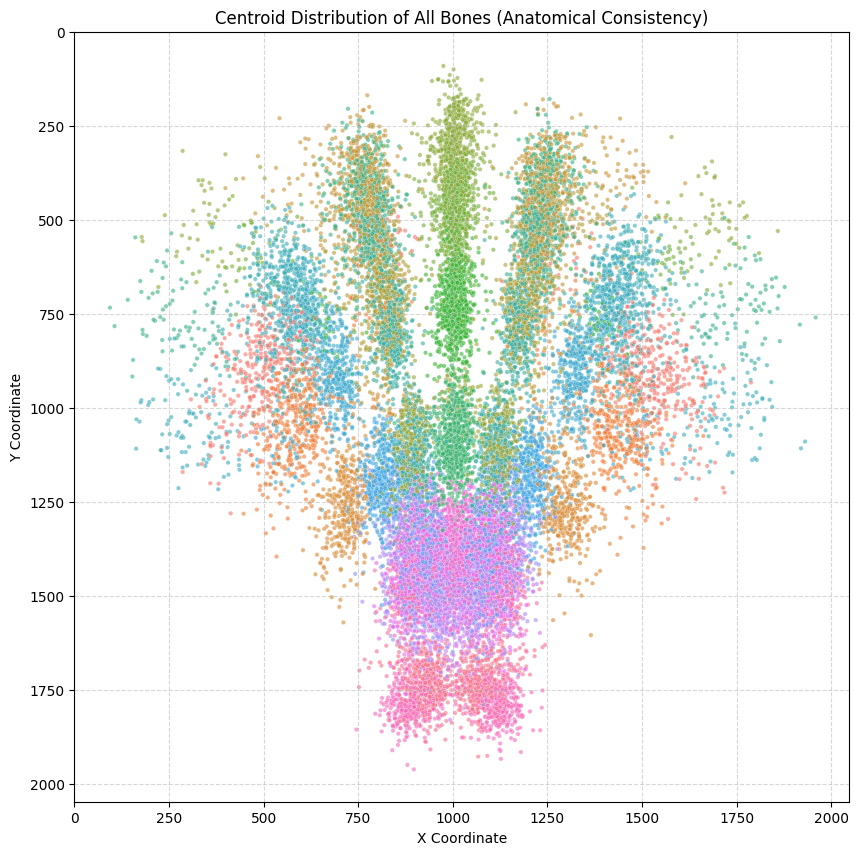

In [8]:
centroid_data = []

print("Analyzing Anatomical Spatial Consistency (Centroids)...")

for json_file in tqdm(jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        
    annotations = data.get('annotations', [])
    
    for ann in annotations:
        label = ann.get('label')
        points = ann.get('points', [])
        
        if len(points) > 2:
            pts = np.array(points, np.int32)
            
            # 무게중심 (Centroid) 계산 (Moments 이용)
            M = cv2.moments(pts)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                centroid_data.append({
                    'label': label,
                    'x': cX,
                    'y': cY,
                    'file': json_file
                })

df_centroid = pd.DataFrame(centroid_data)

# 시각화 (Scatter Plot)
plt.figure(figsize=(10, 10))

# 전체 분포, 색상으로 구분
sns.scatterplot(data=df_centroid, x='x', y='y', hue='label', s=10, alpha=0.6, legend=False)

# 이미지 좌표계에 맞춰 Y축 반전 (이미지는 위가 0)
plt.gca().invert_yaxis()
plt.title("Centroid Distribution of All Bones (Anatomical Consistency)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(0, 2048)
plt.ylim(2048, 0) 

plt.show()

Calculating Bone Overlap Heatmap...


100%|██████████| 800/800 [00:32<00:00, 24.98it/s]


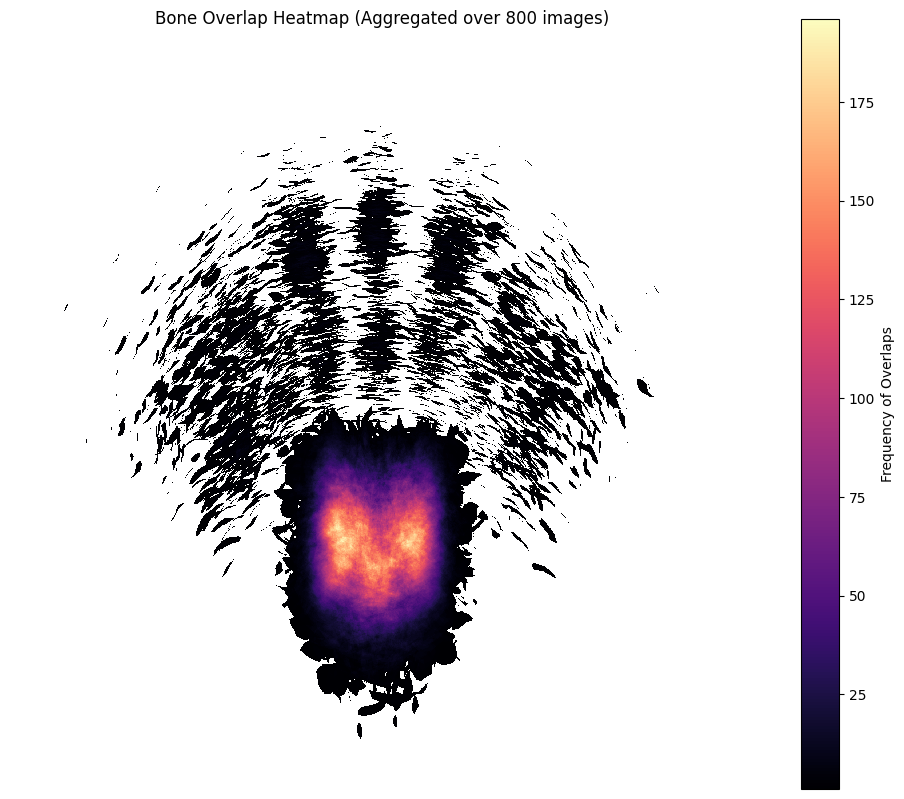

이미지 한 장당 평균적으로 약 19685 픽셀이 겹침 구간입니다.


In [9]:
IMG_H, IMG_W = 2048, 2048 
overlap_accumulator = np.zeros((IMG_H, IMG_W), dtype=np.float32)

print("Calculating Bone Overlap Heatmap...")

count = 0
for json_file in tqdm(jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        
    annotations = data.get('annotations', [])
    
    # 이미지 한 장에 대한 레이어 (0으로 초기화)
    # 여기에 뼈를 하나씩 그릴 때마다 +1을 합니다.
    current_img_layer = np.zeros((IMG_H, IMG_W), dtype=np.uint8)
    
    for ann in annotations:
        points = ann.get('points', [])
        if len(points) > 2:
            pts = np.array(points, np.int32)
            
            # 뼈 하나를 임시 마스크에 그립니다 (값 1)
            temp_mask = np.zeros((IMG_H, IMG_W), dtype=np.uint8)
            cv2.fillPoly(temp_mask, [pts], 1)
            
            # 전체 레이어에 더합니다.
            current_img_layer += temp_mask
            
    # 겹치는 부분 찾기: 픽셀 값이 2 이상인 곳이 겹친 곳입니다.
    # (0: 배경, 1: 뼈 1개, 2 이상: 뼈 겹침)
    overlap_mask = (current_img_layer > 1).astype(np.float32)
    
    # 전체 데이터셋 누적
    overlap_accumulator += overlap_mask
    count += 1

plt.figure(figsize=(12, 10))

overlap_vis = np.copy(overlap_accumulator)
overlap_vis[overlap_vis == 0] = np.nan 

# Heatmap 그리기 ('magma' colormap 추천: 검정->보라->빨강->노랑)
# 노란색일수록 "이 위치에서 뼈들이 엄청 자주 겹친다"는 뜻입니다.
plt.imshow(overlap_vis, cmap='magma', interpolation='nearest')
plt.colorbar(label='Frequency of Overlaps')

plt.title(f"Bone Overlap Heatmap (Aggregated over {count} images)")
plt.axis('off')

plt.show()

# 통계 출력
total_pixels = IMG_H * IMG_W * count
overlap_pixels = np.sum(overlap_accumulator)
print(f"이미지 한 장당 평균적으로 약 {np.sum(overlap_accumulator)/count:.0f} 픽셀이 겹침 구간입니다.")

In [10]:
SCALE_FACTOR = 0.25  
img_w, img_h = 2048, 2048 
w_small, h_small = int(img_w * SCALE_FACTOR), int(img_h * SCALE_FACTOR)

with open(os.path.join(LABEL_ROOT, jsons[0]), 'r') as f:
    first_data = json.load(f)
    class_list = [ann['label'] for ann in first_data['annotations']]

class_to_idx = {name: i for i, name in enumerate(class_list)}
n_classes = len(class_list)

# 결과 저장용 행렬
# [i, j] = i번째 클래스와 j번째 클래스의 겹침 정보
iou_sum_matrix = np.zeros((n_classes, n_classes))
overlap_count_matrix = np.zeros((n_classes, n_classes))

print(f"Calculating Overlap Matrix for {n_classes} classes...")

# 교집합 및 IoU 계산
for json_file in tqdm(jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    annotations = data.get('annotations', [])
    
    # 현재 이미지의 마스크들을 저장할 딕셔너리
    masks = {}
    bboxes = {}

    # 1. 마스크 생성 (스케일 줄여서)
    for ann in annotations:
        label = ann.get('label')
        points = ann.get('points', [])
        
        if label in class_to_idx and len(points) > 2:
            # 좌표 스케일링
            pts = (np.array(points) * SCALE_FACTOR).astype(np.int32)
            
            # 마스크 그리기
            mask = np.zeros((h_small, w_small), dtype=np.uint8)
            cv2.fillPoly(mask, [pts], 1)
            
            masks[label] = mask
            
            # Bounding Box (빠른 계산용)
            x, y, w, h = cv2.boundingRect(pts)
            bboxes[label] = (x, y, x+w, y+h)

    # 2. 모든 쌍(Pair)에 대해 겹침 확인
    # itertools.combinations를 써서 (A, B) 쌍을 생성
    for label_a, label_b in combinations(class_list, 2):
        if label_a not in masks or label_b not in masks:
            continue
            
        # BBox 먼저 확인 (안 겹치면 패스)
        xa1, ya1, xa2, ya2 = bboxes[label_a]
        xb1, yb1, xb2, yb2 = bboxes[label_b]
        
        # 사각형이 겹치지 않는 조건
        if xa2 < xb1 or xb2 < xa1 or ya2 < yb1 or yb2 < ya1:
            continue
            
        # 실제 마스크 교집합 연산
        mask_a = masks[label_a]
        mask_b = masks[label_b]
        
        intersection = np.logical_and(mask_a, mask_b).sum()
        
        if intersection > 0:
            union = np.logical_or(mask_a, mask_b).sum()
            iou = intersection / union if union > 0 else 0
            
            idx_a, idx_b = class_to_idx[label_a], class_to_idx[label_b]
            
            # 행렬에 누적 (대칭 행렬)
            iou_sum_matrix[idx_a, idx_b] += iou
            iou_sum_matrix[idx_b, idx_a] += iou
            
            overlap_count_matrix[idx_a, idx_b] += 1
            overlap_count_matrix[idx_b, idx_a] += 1

# 평균 IoU 계산 (겹친 적이 있는 경우에만 평균)
# 0으로 나누기 방지
avg_iou_matrix = np.divide(iou_sum_matrix, overlap_count_matrix, 
                           out=np.zeros_like(iou_sum_matrix), 
                           where=overlap_count_matrix!=0)

# 자기 자신과의 관계는 의미 없으므로 0 또는 1 (여기선 시각화 편의상 0)
np.fill_diagonal(avg_iou_matrix, 0)
np.fill_diagonal(overlap_count_matrix, 0)

# 3. Plotly Heatmap 시각화
# (1) 평균 IoU 히트맵 (얼마나 심하게 겹치나?)
fig_iou = px.imshow(
    avg_iou_matrix,
    x=class_list,
    y=class_list,
    color_continuous_scale='Reds',
    title="Average IoU Heatmap (Severity of Overlap)",
    labels=dict(x="Class A", y="Class B", color="Avg IoU"),
    template='plotly_white'
)
fig_iou.update_layout(
    width=900, height=900,
    xaxis_title="Class Name", yaxis_title="Class Name"
)
# 마우스 올렸을 때 정보 표시
fig_iou.update_traces(
    hovertemplate="<b>%{x}</b> & <b>%{y}</b><br>Avg IoU: %{z:.3f}<extra></extra>"
)
fig_iou.show()


# (2) 겹침 빈도 히트맵 (얼마나 자주 겹치나?)
fig_count = px.imshow(
    overlap_count_matrix,
    x=class_list,
    y=class_list,
    color_continuous_scale='Blues',
    title=f"Overlap Frequency Heatmap (Count out of {len(jsons)} images)",
    labels=dict(x="Class A", y="Class B", color="Count"),
    template='plotly_white'
)
fig_count.update_layout(
    width=900, height=900,
    xaxis_title="Class Name", yaxis_title="Class Name"
)
fig_count.update_traces(
    hovertemplate="<b>%{x}</b> & <b>%{y}</b><br>Overlap Count: %{z} times<extra></extra>"
)
fig_count.show()

# 가장 심각한 겹침 Top 10 출력
# 상삼각행렬(Upper Triangle)만 추출해서 중복 제거
triu_indices = np.triu_indices(n_classes, k=1)
overlap_list = []

for i, j in zip(*triu_indices):
    if overlap_count_matrix[i, j] > 0:
        overlap_list.append({
            'Class A': class_list[i],
            'Class B': class_list[j],
            'Frequency': int(overlap_count_matrix[i, j]),
            'Avg IoU': avg_iou_matrix[i, j]
        })

df_overlap = pd.DataFrame(overlap_list)
print("\n=== Top 10 Most Frequently Overlapping Pairs ===")
print(df_overlap.sort_values('Frequency', ascending=False).head(10))

print("\n=== Top 10 Most Severely Overlapping Pairs (High IoU) ===")
print(df_overlap.sort_values('Avg IoU', ascending=False).head(10))

Calculating Overlap Matrix for 29 classes...


100%|██████████| 800/800 [00:23<00:00, 34.55it/s]



=== Top 10 Most Frequently Overlapping Pairs ===
       Class A    Class B  Frequency   Avg IoU
32   finger-15  finger-19        800  0.021282
45   Trapezoid  Trapezium        800  0.188486
65      Hamate   Capitate        799  0.057147
64  Triquetrum   Pisiform        799  0.448332
3       Radius     Lunate        799  0.017711
41   finger-19     Hamate        798  0.043857
52    Scaphoid   Capitate        798  0.063840
19    finger-7  Trapezium        797  0.016756
1       Radius   Scaphoid        796  0.017335
58      Lunate   Capitate        795  0.054810

=== Top 10 Most Severely Overlapping Pairs (High IoU) ===
       Class A     Class B  Frequency   Avg IoU
64  Triquetrum    Pisiform        799  0.448332
45   Trapezoid   Trapezium        800  0.188486
48   Trapezoid    Pisiform          1  0.090350
52    Scaphoid    Capitate        798  0.063840
65      Hamate    Capitate        799  0.057147
58      Lunate    Capitate        795  0.054810
41   finger-19      Hamate        798 

Analyzing Shape Complexity & Edge Sharpness (800 samples)...


100%|██████████| 800/800 [02:38<00:00,  5.06it/s]
/tmp/ipykernel_266879/1457346714.py:72: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_266879/1457346714.py:80: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




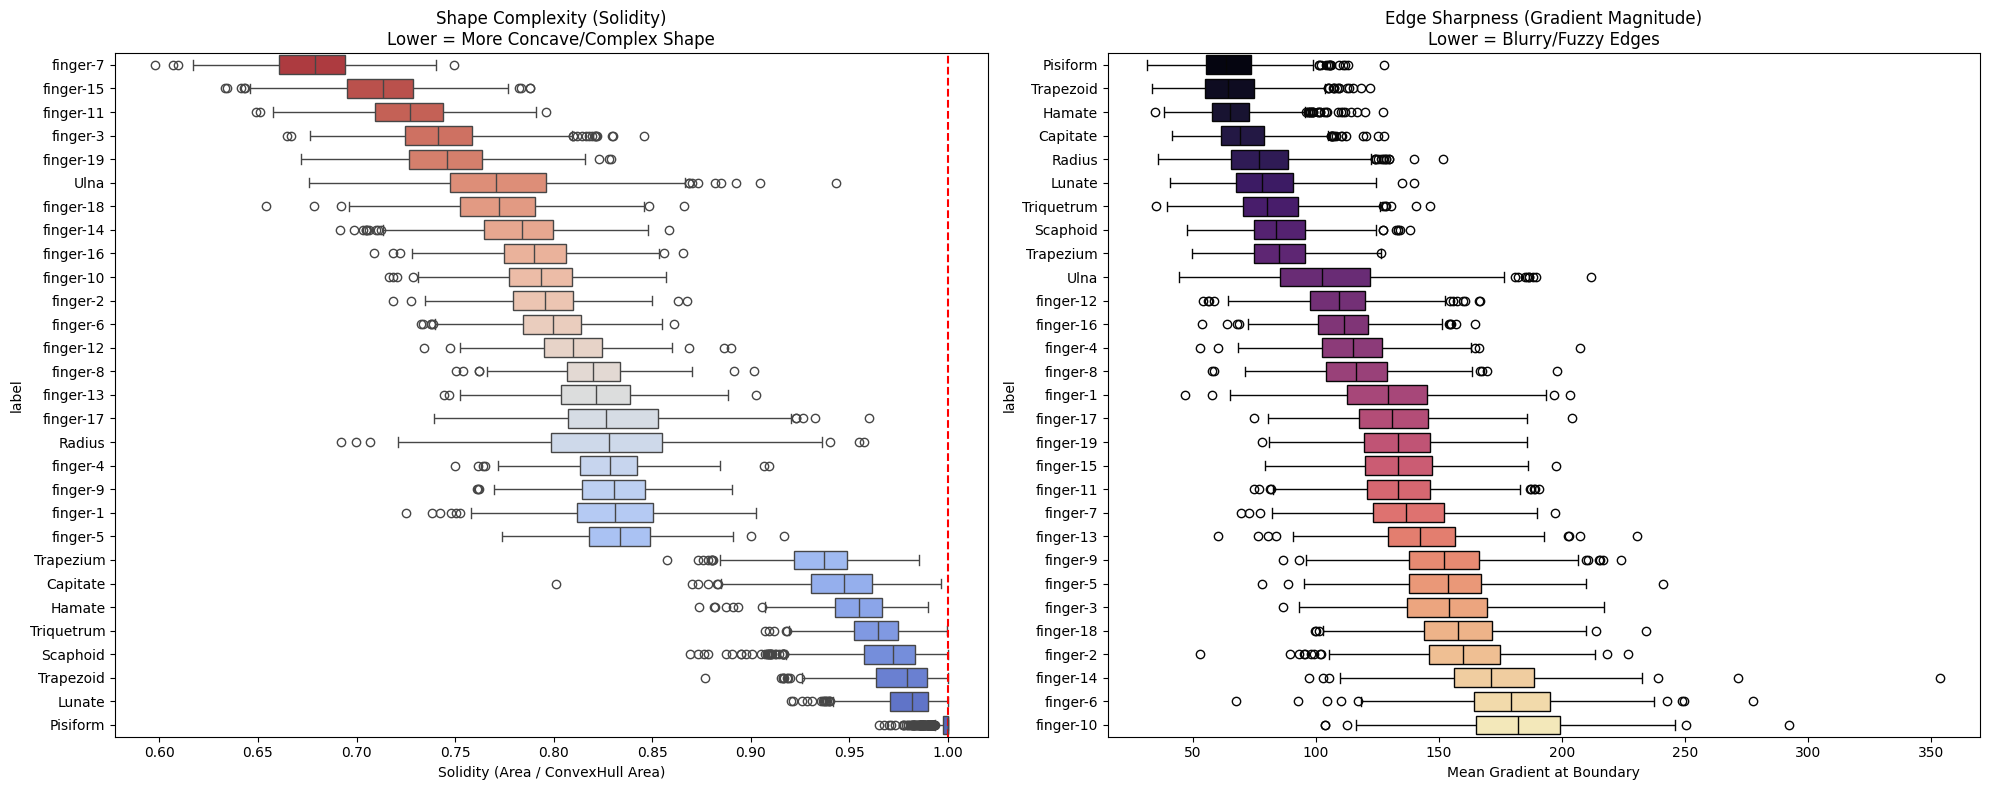


=== Most Complex Shapes (Low Solidity) ===
label
finger-7     0.677747
finger-15    0.712441
finger-11    0.726450
finger-3     0.742939
finger-19    0.744651
Name: solidity, dtype: float64

=== Most Blurry Edges (Low Sharpness) ===
label
Pisiform     64.988466
Trapezoid    66.122322
Hamate       66.558012
Capitate     71.023439
Radius       78.493704
Name: sharpness, dtype: float64


In [11]:
SAMPLE_NUM = 800 
morph_data = []

print(f"Analyzing Shape Complexity & Edge Sharpness ({SAMPLE_NUM} samples)...")

# 랜덤 샘플링
import random
sample_indices = random.sample(range(len(jsons)), min(len(jsons), SAMPLE_NUM))
sample_jsons = [jsons[i] for i in sample_indices]

for json_file in tqdm(sample_jsons):
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        
    png_filename = json_file.replace('.json', '.png')
    img_path = os.path.join(IMAGE_ROOT, png_filename)
    
    # 이미지 로드 (Gradient 계산용)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    
    # 이미지의 Gradient Map 계산 (Sobel Filter)
    # dx, dy로 가로/세로 변화량을 구하고 합칩니다.
    gX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt(gX**2 + gY**2)
    
    annotations = data.get('annotations', [])
    
    for ann in annotations:
        label = ann.get('label')
        points = ann.get('points', [])
        
        if len(points) > 2:
            pts = np.array(points, np.int32)
            
            # 1. Solidity 계산
            area = cv2.contourArea(pts)
            hull = cv2.convexHull(pts)
            hull_area = cv2.contourArea(hull)
            
            solidity = 0
            if hull_area > 0:
                solidity = area / hull_area
            
            # 2. Edge Sharpness 계산
            # 폴리곤의 경계선(Contour) 좌표만 마스킹
            mask_contour = np.zeros_like(img, dtype=np.uint8)
            cv2.drawContours(mask_contour, [pts], -1, 255, 1) # 두께 1
            
            # 경계선 위치의 Gradient 값들만 추출
            edge_gradients = magnitude[mask_contour == 255]
            
            if len(edge_gradients) > 0:
                mean_sharpness = np.mean(edge_gradients)
                
                morph_data.append({
                    'label': label,
                    'solidity': solidity,
                    'sharpness': mean_sharpness
                })

df_morph = pd.DataFrame(morph_data)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# (1) Solidity Plot
# 값이 낮을수록 오목하고 복잡한 뼈
order_solidity = df_morph.groupby('label')['solidity'].median().sort_values().index
sns.boxplot(data=df_morph, x='solidity', y='label', order=order_solidity, palette='coolwarm_r', ax=axes[0])
axes[0].set_title("Shape Complexity (Solidity)\nLower = More Concave/Complex Shape")
axes[0].set_xlabel("Solidity (Area / ConvexHull Area)")
axes[0].axvline(1.0, color='red', linestyle='--') # 기준선

# (2) Edge Sharpness Plot
# 값이 낮을수록 경계가 흐릿함
order_sharpness = df_morph.groupby('label')['sharpness'].median().sort_values().index
sns.boxplot(data=df_morph, x='sharpness', y='label', order=order_sharpness, palette='magma', ax=axes[1])
axes[1].set_title("Edge Sharpness (Gradient Magnitude)\nLower = Blurry/Fuzzy Edges")
axes[1].set_xlabel("Mean Gradient at Boundary")

plt.tight_layout()
plt.show()

# 요약 출력
print("\n=== Most Complex Shapes (Low Solidity) ===")
print(df_morph.groupby('label')['solidity'].mean().sort_values().head(5))

print("\n=== Most Blurry Edges (Low Sharpness) ===")
print(df_morph.groupby('label')['sharpness'].mean().sort_values().head(5))

# META DATA

In [36]:
META_PATH = '/data/ephemeral/home/data/meta_data.xlsx'
print(f"Loading metadata from {META_PATH}...")
df_meta = pd.read_excel(META_PATH)

Loading metadata from /data/ephemeral/home/data/meta_data.xlsx...


In [37]:
df_meta.head()

,ID,나이,성별,체중(몸무게),키(신장),Unnamed: 5
0,1,30,_x0008_여,63.0,165.0,NaN
1,2,21,_x0008_남,70.0,172.0,NaN
2,3,21,_x0008_여,48.0,164.0,NaN
3,4,30,_x0008_여,49.0,158.0,NaN
4,5,33,_x0008_여,50.0,160.0,NaN


In [ ]:
len(df_meta) # train 400명, test 150명 -> 144명

550

In [39]:
# (1) 성별 컬럼: '여', '남' 등 한글만 쏙 뽑아냅니다.
# 특수문자, 공백, 영어, 숫자 등은 모두 무시됩니다.
if '성별' in df_meta.columns:
    # 문자열로 변환 후, 한글(가-힣)에 해당하는 글자만 추출
    df_meta['성별'] = df_meta['성별'].astype(str).str.extract(r'([가-힣]+)')[0]
    
    # 혹시 모를 공백 제거
    df_meta['성별'] = df_meta['성별'].str.strip()

# (2) ID 컬럼 정수 변환 (NaN 처리 포함)
if 'ID' in df_meta.columns:
    # 숫자가 아닌 값이 섞여 있을 수 있으므로 coerce로 처리
    df_meta['ID'] = pd.to_numeric(df_meta['ID'], errors='coerce').fillna(0).astype(int)

# (3) 불필요한 컬럼 제거
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]

print("=== Cleaned Metadata Check ===")
print(df_meta['성별'].unique())  
display(df_meta.head())

=== Cleaned Metadata Check ===
['여' '남']


,ID,나이,성별,체중(몸무게),키(신장)
0,1,30,여,63.0,165.0
1,2,21,남,70.0,172.0
2,3,21,여,48.0,164.0
3,4,30,여,49.0,158.0
4,5,33,여,50.0,160.0


In [18]:

print(f"Searching for JSONs recursively in: {LABEL_ROOT}")
import glob
# glob을 사용하여 모든 하위 폴더의 json 파일을 찾습니다.
# recursive=True를 쓰면 하위 폴더까지 다 뒤집니다.
json_paths = glob.glob(os.path.join(LABEL_ROOT, '**', '*.json'), recursive=True)

file_data = []

print(f"Found {len(json_paths)} JSON files in total.")

for json_path in json_paths:
    # 1. 전체 경로에서 파일명과 상위 폴더명을 분리
    folder_path = os.path.dirname(json_path)  # .../train_label/ID001
    file_name = os.path.basename(json_path)   # 166113...json
    
    # 2. 상위 폴더명 추출 (예: 'ID001')
    folder_name = os.path.basename(folder_path)
    
    # 3. 폴더명에서 숫자 ID 추출
    numbers = re.findall(r'\d+', folder_name)
    
    if numbers:
        # 'ID001' -> 1, '1' -> 1
        folder_id = int(numbers[-1])
        
        file_data.append({
            'file_name': file_name,     # 나중에 이미지 매칭용
            'json_path': json_path,     # 파일 열 때 사용
            'folder_name': folder_name, # 확인용
            'ID': folder_id             # 메타데이터 매칭 Key
        })

# 데이터프레임 생성
df_files = pd.DataFrame(file_data)

print("\n=== Extracted IDs from Folder Names ===")
if not df_files.empty:
    print(df_files[['folder_name', 'ID', 'file_name']].head())
else:
    print("Error: 파일을 찾지 못했거나 폴더명에서 숫자를 추출하지 못했습니다.")

# ==========================================
# 3. 데이터 병합 (Merge)
# ==========================================
if not df_files.empty:
    df_merged = pd.merge(df_files, df_meta, on='ID', how='inner')
    
    print(f"\nSuccessfully Merged: {len(df_merged)} images.")

Searching for JSONs recursively in: /data/ephemeral/home/data/train/outputs_json
Found 800 JSON files in total.

=== Extracted IDs from Folder Names ===
  folder_name   ID                file_name
0       ID453  453  image1666573743950.json
1       ID453  453  image1666573768043.json
2       ID091   91  image1661821945630.json
3       ID091   91  image1661821925422.json
4       ID098   98  image1661823451031.json

Successfully Merged: 800 images.


/tmp/ipykernel_266879/2360766670.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2360766670.py:25: UserWarning:

Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.

/tmp/ipykerne

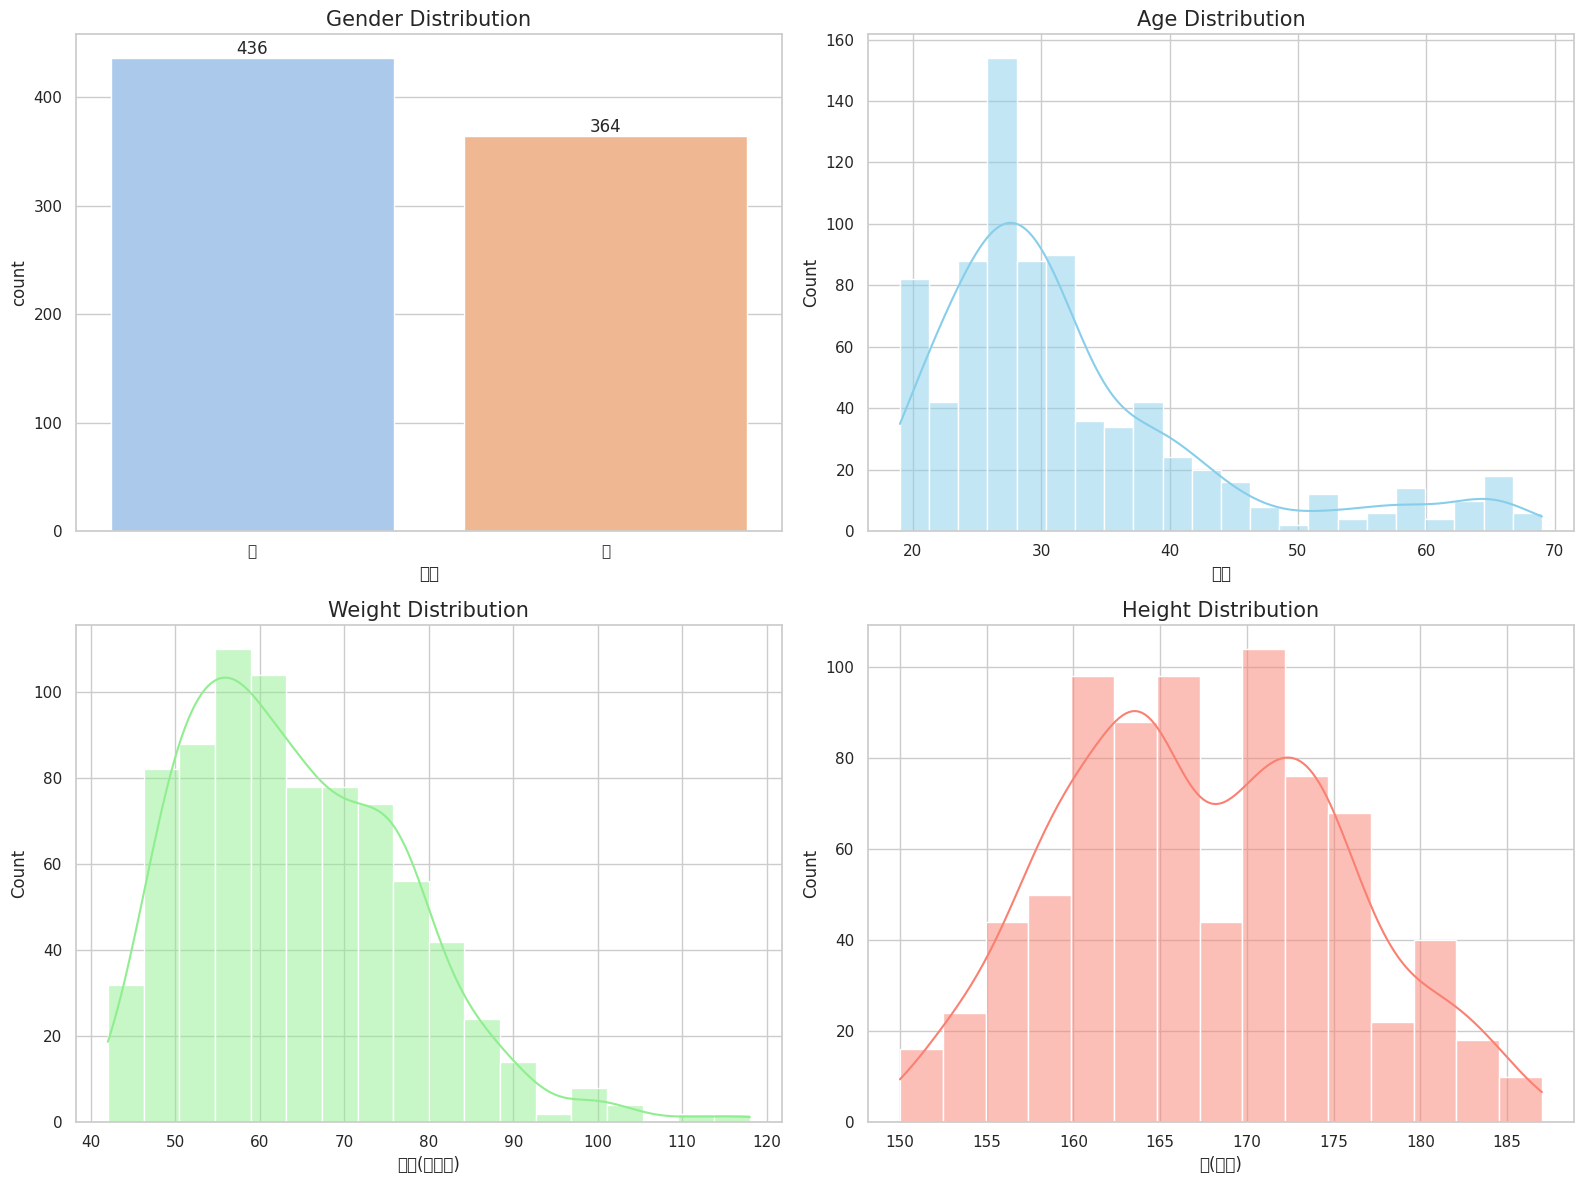


=== Gender-based Statistics (Mean/Std) ===


성별                      남           여
나이      count  364.000000  436.000000
        mean    31.978022   32.715596
        std     11.407289   10.704037
        min     19.000000   19.000000
        25%     26.000000   25.000000
        50%     28.000000   30.000000
        75%     34.000000   38.000000
        max     69.000000   67.000000
키(신장)   count  364.000000  436.000000
        mean   174.021429  161.788532
        std      5.563956    5.057218
        min    158.000000  150.000000
        25%    171.000000  158.000000
        50%    174.000000  162.000000
        75%    177.000000  165.000000
        max    187.000000  176.000000
체중(몸무게) count  364.000000  436.000000
        mean    73.775275   56.355046
        std     10.271831    8.812452
        min     53.000000   42.000000
        25%     67.000000   50.000000
        50%     74.000000   55.000000
        75%     79.000000   60.000000
        max    118.000000  112.000000

In [25]:
# 시각화 설정
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 성별 분포 (Count Plot)
ax1 = sns.countplot(data=df_merged, x='성별', palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution', fontsize=15)
for container in ax1.containers:
    ax1.bar_label(container, fontsize=12)

# 2. 나이 분포 (KDE Plot)
# 연령대가 어디에 집중되어 있는지 확인
sns.histplot(data=df_merged, x='나이', kde=True, color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution', fontsize=15)

# 3. 체중 분포
sns.histplot(data=df_merged, x='체중(몸무게)', kde=True, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Weight Distribution', fontsize=15)

# 4. 키 분포
sns.histplot(data=df_merged, x='키(신장)', kde=True, color='salmon', ax=axes[1, 1])
axes[1, 1].set_title('Height Distribution', fontsize=15)

plt.tight_layout()
plt.show()

# === [통계 요약 출력] ===
# 성별에 따른 평균 키, 몸무게, 나이 확인
print("\n=== Gender-based Statistics (Mean/Std) ===")
display(df_merged.groupby('성별')[['나이', '키(신장)', '체중(몸무게)']].describe().T)

In [21]:
df_merged.head().json_path

0    /data/ephemeral/home/data/train/outputs_json/I...
1    /data/ephemeral/home/data/train/outputs_json/I...
2    /data/ephemeral/home/data/train/outputs_json/I...
3    /data/ephemeral/home/data/train/outputs_json/I...
4    /data/ephemeral/home/data/train/outputs_json/I...
Name: json_path, dtype: object

Extracting features from 800 images based on Metadata...


100%|██████████| 800/800 [00:06<00:00, 129.64it/s]
/tmp/ipykernel_266879/2239473266.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_266879/2239473266.py:73: UserWarning:

Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_266879/2239473266.py:73: UserWarning:

Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.

/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.

/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.



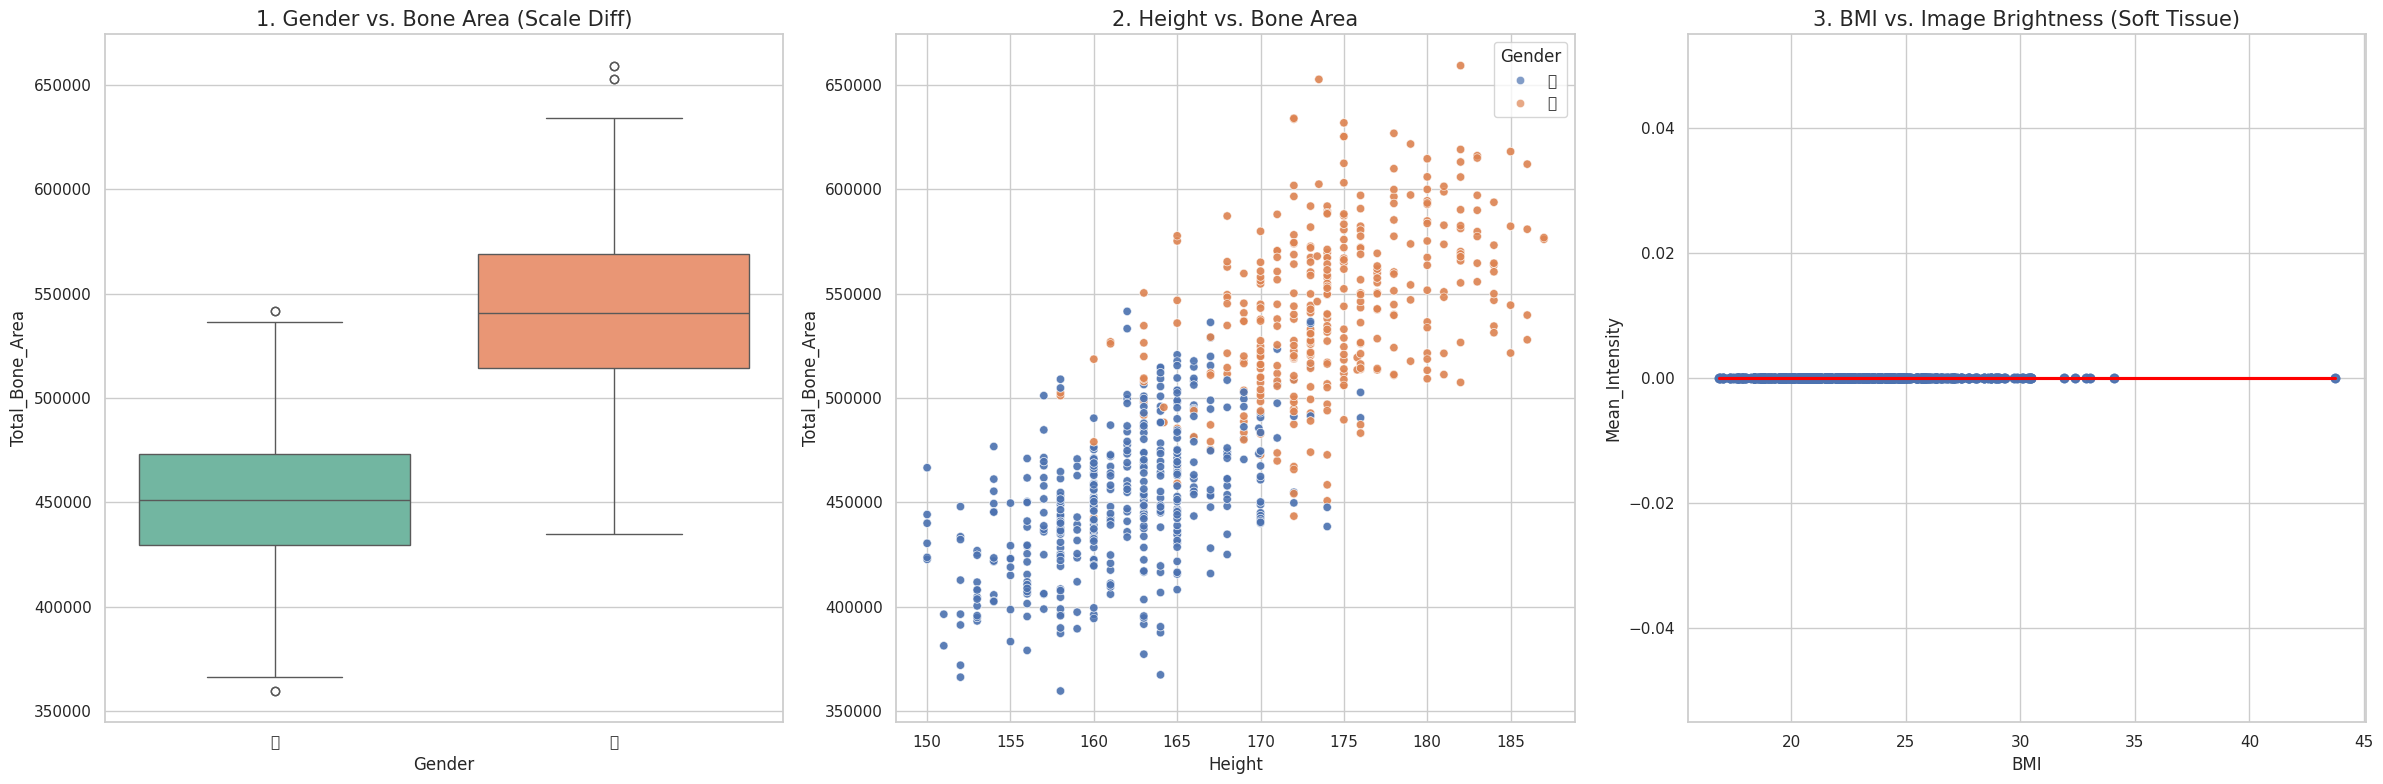


=== [Conclusion for Modeling] ===
1. Scale Check: 남성 뼈가 여성보다 약 1.20배 큽니다.
   ACTION: 크기 차이가 크지 않습니다. 약한 Scale 증강만 있어도 됩니다.

2. Intensity Check: BMI와 밝기의 상관계수는 nan 입니다.
   ACTION: BMI가 화질에 큰 영향을 주지 않는 깨끗한 데이터셋입니다.


/data/ephemeral/home/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/data/ephemeral/home/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



In [26]:
# ==========================================
# 1. 특징 추출 (Feature Extraction)
# ==========================================
# 20~30대 데이터이므로 BMI(비만도)가 화질에 미치는 영향이 더 중요할 수 있습니다.
# BMI = 몸무게(kg) / (키(m) ^ 2)
df_merged['Height_m'] = df_merged['키(신장)'] / 100
df_merged['BMI'] = df_merged['체중(몸무게)'] / (df_merged['Height_m'] ** 2)

image_stats = []

print("Extracting features from 800 images based on Metadata...")

for idx, row in tqdm(df_merged.iterrows(), total=len(df_merged)):
    # 1. JSON 경로 (병합된 데이터프레임에 있다고 가정)
    json_path = row['json_path']
    
    # 2. 이미지 경로 유추 (train_label -> train_input, .json -> .png)
    # 실제 폴더 구조에 맞춰주세요. 보통 label 폴더와 input 폴더가 형제 관계입니다.
    img_path = json_path.replace('train_label', 'train_input').replace('.json', '.png')
    
    # (1) 뼈 면적 계산 (Scale 확인용)
    total_area = 0
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        for ann in data.get('annotations', []):
            pts = ann.get('points', [])
            if len(pts) > 2:
                total_area += cv2.contourArea(np.array(pts, np.int32))
    except Exception as e:
        pass # 에러 무시

    # (2) 이미지 밝기 계산 (Contrast 확인용)
    mean_intensity = 0
    if os.path.exists(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            mean_intensity = np.mean(img)
    
    image_stats.append({
        'ID': row['ID'],
        'Total_Bone_Area': total_area,
        'Mean_Intensity': mean_intensity
    })

# 데이터 합치기
df_stats = pd.DataFrame(image_stats)
df_final = pd.merge(df_merged, df_stats, on='ID')

# 컬럼명 영문 변환 (시각화 오류 방지)
df_final = df_final.rename(columns={'성별': 'Gender', '나이': 'Age', '키(신장)': 'Height', '체중(몸무게)': 'Weight'})

# ==========================================
# 2. 시각화 (Insight 도출)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# [Graph 1] 성별에 따른 뼈 크기 차이 (Boxplot)
# 남녀 크기 차이가 크다면 -> RandomScale Augmentation 필수
sns.boxplot(data=df_final, x='Gender', y='Total_Bone_Area', palette='Set2', ax=axes[0])
axes[0].set_title("1. Gender vs. Bone Area (Scale Diff)", fontsize=15)

# [Graph 2] 키와 뼈 크기의 상관관계 (Scatter)
# 키가 클수록 뼈가 큰가? (당연하겠지만 눈으로 확인)
sns.scatterplot(data=df_final, x='Height', y='Total_Bone_Area', hue='Gender', alpha=0.7, ax=axes[1])
axes[1].set_title("2. Height vs. Bone Area", fontsize=15)

# [Graph 3] BMI와 이미지 밝기 (Scatter + Reg)
# 뚱뚱한 사람(BMI High)의 사진이 더 어두운가? -> Contrast Augmentation 필수
sns.regplot(data=df_final, x='BMI', y='Mean_Intensity', scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[2])
axes[2].set_title("3. BMI vs. Image Brightness (Soft Tissue)", fontsize=15)

plt.tight_layout()
plt.show()

# ==========================================
# 3. 결론 출력 (Action Item)
# ==========================================
male_mean = df_final[df_final['Gender']=='남']['Total_Bone_Area'].mean()
female_mean = df_final[df_final['Gender']=='여']['Total_Bone_Area'].mean()
scale_ratio = male_mean / female_mean

print(f"\n=== [Conclusion for Modeling] ===")
print(f"1. Scale Check: 남성 뼈가 여성보다 약 {scale_ratio:.2f}배 큽니다.")
if scale_ratio > 1.2:
    print("   ✅ ACTION: 성별 간 크기 차이가 뚜렷합니다. RandomScale(0.5 ~ 1.5) 증강을 꼭 적용하세요.")
else:
    print("   ACTION: 크기 차이가 크지 않습니다. 약한 Scale 증강만 있어도 됩니다.")

corr_bmi = df_final['BMI'].corr(df_final['Mean_Intensity'])
print(f"\n2. Intensity Check: BMI와 밝기의 상관계수는 {corr_bmi:.2f} 입니다.")
if corr_bmi < -0.3:
    print("   ✅ ACTION: 체중이 나갈수록 사진이 어둡습니다. CLAHE나 RandomBrightnessContrast를 강하게 적용하세요.")
else:
    print("   ACTION: BMI가 화질에 큰 영향을 주지 않는 깨끗한 데이터셋입니다.")